# &#x1F4D1; &nbsp;  $\mathfrak {\color{#191970} {P5: \ Build \ a \ Digit \ Recognition \ Program. \ Step \ 3}}$

---
## $\mathfrak {\color{#191970} {Code \ Library \ and \ Links}}$
Multi-dimensional image processing https://docs.scipy.org/doc/scipy/reference/ndimage.html

Keras: Deep Learning library for Theano and TensorFlow https://keras.io/
 
Deep MNIST for Experts https://www.tensorflow.org/get_started/mnist/pros

Tensorflow Deep MNIST Advanced Tutorial http://docs.seldon.io/tensorflow-deep-mnist-example.html

Handwritten Digit Recognition using Convolutional Neural Networks in Python with Keras

http://machinelearningmastery.com/handwritten-digit-recognition-using-convolutional-neural-networks-python-keras/

In [1]:
from IPython.core.display import HTML
hide_code = ''
HTML('''
<script>
code_show = true; 
function code_display() {
    if (code_show) {
        $('div.input').each(function(id) {
            if (id == 0 || $(this).html().indexOf('hide_code') > -1) {$(this).hide();}
        });
        $('div.output_prompt').css('opacity', 0);
    } else {
        $('div.input').each(function(id) {$(this).show();});
        $('div.output_prompt').css('opacity', 1);
    }
    code_show = !code_show;
} 
$(document).ready(code_display);
</script>
<form action="javascript: code_display()">
<input style="color: #191970; background: ghostwhite; opacity: 0.9; " \
type="submit" value="Click to display or hide code">
</form>
''')

In [2]:
hide_code
import numpy as np
import pandas as pd

import cv2

import scipy as sp
import scipy.ndimage
import scipy.misc
from scipy.special import expit

import random
from time import time

import os
import sys

import h5py
import tarfile

from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

import tensorflow as tf
import tensorflow.examples.tutorials.mnist as mnist

from skimage.feature import hog
from sklearn.externals import joblib
from sklearn.neural_network import MLPClassifier, BernoulliRBM
from sklearn import linear_model, datasets, metrics
from sklearn.pipeline import Pipeline
from sklearn import manifold, decomposition, ensemble
from sklearn import discriminant_analysis, random_projection
from sklearn.model_selection import train_test_split

import keras as ks
from keras.models import Sequential, load_model, Model
from keras.preprocessing import sequence
from keras.optimizers import SGD, RMSprop
from keras.layers import Dense, Dropout, LSTM
from keras.layers import Activation, Flatten, Input, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, Conv2D, MaxPooling2D
from keras.layers.embeddings import Embedding

from IPython.display import display, Image, IFrame
import matplotlib.pylab as plt
import matplotlib.cm as cm
from matplotlib import offsetbox
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [3]:
hide_code
def fivedigit_label(label):
    size = len(label)
    if size >= 5:
        return label
    else:
        num_zeros = np.full((5-size), 10)
        return np.array(np.concatenate((num_zeros, label), axis = 0))
    
def get_filenames(folder):
    image_path = os.path.join(folder)
    return np.array([f for f in os.listdir(image_path) if f.endswith('.png')])

def get_image(folder, image_file):
    filename=os.path.join(folder, image_file)
    image = scipy.ndimage.imread(filename, mode='RGB')
    
    if folder == 'new':
        n = np.where(new_filenames == image_file)[0]
        label = new_labels[n]
        
    image64_1 = scipy.misc.imresize(image, (32, 32, 3))/255
    image64_2 = np.dot(np.array(image64_1, dtype='float32'), [0.299, 0.587, 0.114])
    
    return image64_1, image64_2, label

def digit_to_categorical(data):
    n = data.shape[1]
    data_cat = np.empty([len(data), n, 11])
    
    for i in range(n):
        data_cat[:, i] = ks.utils.to_categorical(data[:, i], num_classes=11)
        
    return data_cat

In [4]:
hide_code
def get_image2(folder, image_file, boxes):
    filename=os.path.join(folder, image_file)
    image = scipy.ndimage.imread(filename, mode='RGB')
    box = boxes.loc[image_file]
    image = image[box[0]:box[1], box[2]:box[3]]
    
    if folder == 'new':
        n = np.where(new_filenames == image_file)[0]
        label = new_labels[n]
        
    image32_1 = scipy.misc.imresize(image, (32, 32, 3))/255
    image32_2 = np.dot(np.array(image32_1, dtype='float32'), [0.299, 0.587, 0.114])
    
    return image32_1, image32_2, label

def get_image3(folder, image_file, boxes):
    filename=os.path.join(folder, image_file)
    image = cv2.imread(filename)
    box = boxes.loc[image_file]
    image = image[box[0]:box[1], box[2]:box[3]]
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#    image_hist = cv2.equalizeHist(image_gray)
    image_r = cv2.resize(image_gray,(32, 32), interpolation = cv2.INTER_CUBIC)
    
    if folder == 'new':
        n = np.where(new_filenames == image_file)[0]
        label = new_labels[n]
    
    return image_r, label

def get_image4(folder, image_file):
    filename = os.path.join(folder, image_file)
    img = scipy.ndimage.imread(filename, mode='RGB')
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    im_gray = cv2.GaussianBlur(img_gray, (7, 7), 0)
    edges = cv2.Canny(im_gray, 120, 255)
    rectangle = cv2.boundingRect(edges)
    n1, n2, n3, n4 = rectangle[1], rectangle[1]+rectangle[3], rectangle[0], rectangle[0]+rectangle[2]
    if (n2 == 0): n2 = img.shape[0]
    if (n4 == 0): n4 = img.shape[1]
    image_box = img_gray[n1:n2, n3:n4]
    image_resize = scipy.misc.imresize(image_box, (32, 32))
    return image_resize

---
## $\mathfrak {\color{#191970} {Experimental \ Datasets}}$

#### Dataset #6. Newly-Captured Images
####  &nbsp;
<div style="width: 230px; height: 230px; overflow:auto;">
    <img src="new/1.png" width="200" height="200"/>
    <img src="new/10.png" width="200" height="200"/>
    <img src="new/11.png" width="200" height="200"/>
	<img src="new/12.png" width="200" height="200"/>
	<img src="new/13.png" width="200" height="200"/>
	<img src="new/14.png" width="200" height="200"/>
	<img src="new/15.png" width="200" height="200"/>
	<img src="new/16.png" width="200" height="200"/>
	<img src="new/17.png" width="200" height="200"/>
	<img src="new/18.png" width="200" height="200"/>
	<img src="new/19.png" width="200" height="200"/>    
	<img src="new/2.png" width="200" height="200"/>
    <img src="new/20.png" width="200" height="200"/>
    <img src="new/21.png" width="200" height="200"/> 
    <img src="new/22.png" width="200" height="200"/>
    <img src="new/23.png" width="200" height="200"/>
    <img src="new/24.png" width="200" height="200"/>
    <img src="new/25.png" width="200" height="200"/>
    <img src="new/26.png" width="200" height="200"/> 
    <img src="new/27.png" width="200" height="200"/>
    <img src="new/28.png" width="200" height="200"/>
    <img src="new/29.png" width="200" height="200"/>        
	<img src="new/3.png" width="200" height="200"/>
	<img src="new/30.png" width="200" height="200"/>    
	<img src="new/4.png" width="200" height="200"/>
	<img src="new/5.png" width="200" height="200"/>
	<img src="new/6.png" width="200" height="200"/>
	<img src="new/7.png" width="200" height="200"/>
	<img src="new/8.png" width="200" height="200"/>
	<img src="new/9.png" width="200" height="200"/>
</div>

In [5]:
hide_code
new_filenames = get_filenames('new')
print('New files list:\n', new_filenames)

new_labels = [[8], [5, 6, 3], [5, 7], [6], [6, 1, 1],
              [8], [5, 9], [1, 0, 1], [1, 0, 0, 0], [1, 9, 1, 3], 
              [4], [1], [3, 4, 4], [2, 4, 4, 8], [1, 5], 
              [7], [7, 8, 2, 2], [6, 4, 8], [2], [3, 0],              
              [3], [4, 3], [2, 0, 1, 0], [7, 8, 3], [1, 0, 1, 1], 
              [7], [1, 0], [2], [9], [8]]
new_labels = np.array([fivedigit_label(new_labels[i]) for i in range(len(new_labels))])
print('New labels: \n',new_labels)

New files list:
 ['1.png' '10.png' '11.png' '12.png' '13.png' '14.png' '15.png' '16.png'
 '17.png' '18.png' '19.png' '2.png' '20.png' '21.png' '22.png' '23.png'
 '24.png' '25.png' '26.png' '27.png' '28.png' '29.png' '3.png' '30.png'
 '4.png' '5.png' '6.png' '7.png' '8.png' '9.png']
New labels: 
 [[10 10 10 10  8]
 [10 10  5  6  3]
 [10 10 10  5  7]
 [10 10 10 10  6]
 [10 10  6  1  1]
 [10 10 10 10  8]
 [10 10 10  5  9]
 [10 10  1  0  1]
 [10  1  0  0  0]
 [10  1  9  1  3]
 [10 10 10 10  4]
 [10 10 10 10  1]
 [10 10  3  4  4]
 [10  2  4  4  8]
 [10 10 10  1  5]
 [10 10 10 10  7]
 [10  7  8  2  2]
 [10 10  6  4  8]
 [10 10 10 10  2]
 [10 10 10  3  0]
 [10 10 10 10  3]
 [10 10 10  4  3]
 [10  2  0  1  0]
 [10 10  7  8  3]
 [10  1  0  1  1]
 [10 10 10 10  7]
 [10 10 10  1  0]
 [10 10 10 10  2]
 [10 10 10 10  9]
 [10 10 10 10  8]]


Image size:  (32, 32, 3)
Image label:  [[10 10  7  8  3]]

Example of image preprocessing


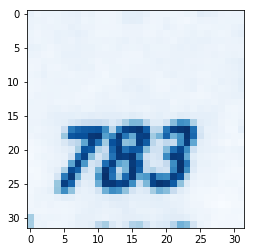

In [6]:
hide_code
image_example = get_image('new', '30.png')

print("Image size: ", image_example[0].shape)
print("Image label: ", image_example[2])
print('\nExample of image preprocessing')
plt.imshow(image_example[1], cmap=plt.cm.Blues);

In [7]:
hide_code
new_images1 = np.array([get_image('new', x)[0] for x in new_filenames])
new_images2 = np.array([get_image('new', x)[1] for x in new_filenames])

#### The '.pickle' file

In [8]:
hide_code
pickle_file = 'new_digits.pickle'

try:
    f = open(pickle_file, 'wb')
    save = {'new_images1': new_images1, 'new_images2': new_images2,
            'new_labels': new_labels, 'new_filenames': new_filenames}
    pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
    f.close()
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise
    
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 985369


In [9]:
hide_code
pickle_file = 'new_digits.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    new_images1 = save['new_images1']
    new_images2 = save['new_images2']
    new_labels = save['new_labels']
    new_filenames = save['new_filenames']
    del save
    
print('Number of new images: ', len(new_images1))


Number of new images:  30


In [10]:
hide_code
new_labels_cat = digit_to_categorical(new_labels)
print('The sixth dataset')
print("Shape of the features - {}, shape of the target - {}".\
      format(new_images2.shape, new_labels_cat.shape))

The sixth dataset
Shape of the features - (30, 32, 32), shape of the target - (30, 5, 11)


In [11]:
hide_code
X_new = new_images2.reshape(30, 32, 32, 1)
y_new_cat_list = [new_labels_cat[:, i] for i in range(5)]

File:  30.png
Label:  [10 10  7  8  3]
Categorical label: 
 [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]]

Example of loaded images


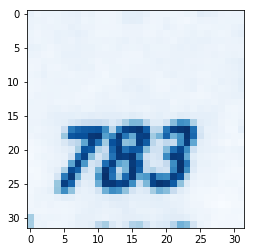

In [12]:
hide_code
print ('File: ', new_filenames[23])
print ('Label: ', new_labels[23])
print ('Categorical label: \n', new_labels_cat[23])
print('\nExample of loaded images')
plt.imshow(new_images2[23], cmap=plt.cm.Blues);

#### The image boxes

In [14]:
hide_code
boxes = np.array([[10, 120, 15, 100], [20, 55, 0, 120], [5, 90, 15, 140], [100, 500, 200, 500], [20, 100, 30, 160],
                 [5, 220, 70, 250], [10, 180, 20, 130], [5, 100, 15, 110], [10, 120, 10, 220], [150, 400, 10, 480],
                 [30, 150, 0, 100], [70, 220, 80, 210], [130, 250, 80, 300], [10, 60, 5, 155], [40, 80, 60, 110],
                 [0, 120, 0, 100], [40, 90, 10, 170], [40, 80, 30, 130], [30, 180, 20, 140], [70, 120, 40, 90],
                 [10, 140, 20, 90], [20, 120, 0, 130], [20, 140, 10, 290], [60, 120, 10, 110], [10, 140, 10, 340],
                 [20, 150, 20, 130], [10, 170, 20, 190], [10, 230, 20, 170], [10, 240, 200, 400], [10, 140, 20, 150]])

new_boxes = pd.DataFrame(data=boxes, index = new_filenames)
new_boxes.head(7)

,0,1,2,3
1.png,10,120,15,100
10.png,20,55,0,120
11.png,5,90,15,140
12.png,100,500,200,500
13.png,20,100,30,160
14.png,5,220,70,250
15.png,10,180,20,130


In [15]:
hide_code
new_images1_2 = np.array([get_image2('new', x, new_boxes)[0] for x in new_filenames])
new_images2_2 = np.array([get_image2('new', x, new_boxes)[1] for x in new_filenames])

X_new2 = new_images2_2.reshape(30, 32, 32, 1)

File:  10.png
Label:  [10 10  5  6  3]
Categorical label: 
 [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]]

Example of loaded images


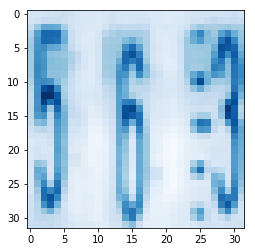

In [16]:
hide_code
print ('File: ', new_filenames[1])
print ('Label: ', new_labels[1])
print ('Categorical label: \n', new_labels_cat[1])
print('\nExample of loaded images')
plt.imshow(new_images2_2[1], cmap=plt.cm.Blues);

#### With image boxes. OpenCV

In [17]:
hide_code
new_images2_3 = np.array([get_image3('new', x, new_boxes)[0] for x in new_filenames])

X_new3 = new_images2_3.reshape(30, 32, 32, 1)

---
## $\mathfrak {\color{#191970} {Step \ 3: \ Test \ a \ Model \ on \ Newly-Captured \ Images}}$

Take several pictures of numbers that you find around you (at least five), and run them through your classifier on your computer to produce example results. Alternatively (optionally), you can try using OpenCV / SimpleCV / Pygame to capture live images from a webcam and run those through your classifier.

#### Load models

In [19]:
hide_code
cnn_model = load_model('cnn_model_file1_1.h5')

In [20]:
hide_code
cnn_model2 = load_model('cnn_model2_file1_1.h5')

#### Predictions without boxes

In [24]:
hide_code
y_new_predict = cnn_model.predict(X_new)

y_predict = []
for i in range(30):
    for j in range(5):
        y_predict.append(np.argmax(y_new_predict[j][i]))
y_predict = np.array(y_predict).reshape(30,5)
print('CNN Model 1. Predictions: ')
print(y_predict)

CNN Model 1. Predictions: 
[[10 10 10 10  8]
 [10 10 10  2  2]
 [10 10 10  5  7]
 [10 10 10 10  6]
 [10 10  6  4  0]
 [10 10 10 10  3]
 [10 10 10  5  9]
 [10 10  1  0  1]
 [10  1  0  0  0]
 [10  1  0  0  0]
 [10 10 10  2  1]
 [10 10 10 10  1]
 [10  1  3  4  1]
 [10  2  2  4  4]
 [10 10 10 10  4]
 [10 10 10  7  7]
 [10 10 10  6  4]
 [10 10  1  0  9]
 [10 10 10  2  2]
 [10 10  1  6  0]
 [10 10 10 10  3]
 [10 10 10  4  3]
 [10  2  0  1  0]
 [10 10 10  2  8]
 [10  1  0  9  0]
 [10 10 10 10  7]
 [10 10 10  1  0]
 [10 10 10 10  2]
 [10 10 10  1  5]
 [10 10 10 10  8]]


In [23]:
hide_code
y_new_predict_2 = cnn_model2.predict(X_new)

y_predict_2 = []
for i in range(30):
    for j in range(5):
        y_predict_2.append(np.argmax(y_new_predict_2[j][i]))
y_predict_2 = np.array(y_predict_2).reshape(30,5)
print('CNN Model 2. Predictions: ')
print(y_predict_2)

CNN Model 2. Predictions: 
[[10 10 10 10  8]
 [10 10 10 10  2]
 [10 10 10  5  7]
 [10 10 10 10  6]
 [10 10  6  6  1]
 [10 10 10 10  4]
 [10 10 10  5  9]
 [10 10  1  0  1]
 [10  1  0  0  0]
 [10 10  1  9  1]
 [10 10 10  1  1]
 [10 10 10 10  1]
 [10 10  2  4  4]
 [10 10 10  4  4]
 [10 10 10  1  1]
 [10 10 10  7  7]
 [10  1  1  8  4]
 [10 10  1  6  0]
 [10 10 10 10  2]
 [10 10  1  2  6]
 [10 10 10 10  3]
 [10 10 10  4  3]
 [10  2  0  1  0]
 [10 10 10  6  5]
 [10  1  0  4  1]
 [10 10 10 10  2]
 [10 10 10  1  0]
 [10 10 10 10  2]
 [10 10 10  1  9]
 [10 10 10 10  8]]


In [25]:
hide_code
cnn_scores = cnn_model.evaluate(X_new, y_new_cat_list, verbose=0)

print("CNN Model 1. Scores: \n" , (cnn_scores))
print("CNN Model 1. First digit. Accuracy: %.2f%%" % (cnn_scores[6]*100))
print("CNN Model 1. Second digit. Accuracy: %.2f%%" % (cnn_scores[7]*100))
print("CNN Model 1. Third digit. Accuracy: %.2f%%" % (cnn_scores[8]*100))
print("CNN Model 1. Fourth digit. Accuracy: %.2f%%" % (cnn_scores[9]*100))
print("CNN Model 1. Fifth digit. Accuracy: %.2f%%" % (cnn_scores[10]*100))

CNN Model 1. Scores: 
 [3.9509024620056152, 0.0033152017276734114, 0.37000522017478943, 0.97824245691299438, 1.5202687978744507, 1.0790706872940063, 1.0, 0.93333333730697632, 0.76666665077209473, 0.56666666269302368, 0.56666666269302368]
CNN Model 1. First digit. Accuracy: 100.00%
CNN Model 1. Second digit. Accuracy: 93.33%
CNN Model 1. Third digit. Accuracy: 76.67%
CNN Model 1. Fourth digit. Accuracy: 56.67%
CNN Model 1. Fifth digit. Accuracy: 56.67%


In [26]:
hide_code
avg_accuracy = sum([cnn_scores[i] for i in range(6, 11)])/5

print("CNN Model 1. Average Accuracy: %.2f%%" % (avg_accuracy*100))

CNN Model 1. Average Accuracy: 76.67%


In [27]:
hide_code
cnn_scores_2 = cnn_model2.evaluate(X_new, y_new_cat_list, verbose=0)

print("CNN Model 2. Scores: \n" , (cnn_scores_2))
print("CNN Model 2. First digit. Accuracy: %.2f%%" % (cnn_scores_2[6]*100))
print("CNN Model 2. Second digit. Accuracy: %.2f%%" % (cnn_scores_2[7]*100))
print("CNN Model 2. Third digit. Accuracy: %.2f%%" % (cnn_scores_2[8]*100))
print("CNN Model 2. Fourth digit. Accuracy: %.2f%%" % (cnn_scores_2[9]*100))
print("CNN Model 2. Fifth digit. Accuracy: %.2f%%" % (cnn_scores_2[10]*100))

CNN Model 2. Scores: 
 [4.7295913696289062, 0.00097239279421046376, 0.60850048065185547, 1.2815195322036743, 1.8604972362518311, 0.97810155153274536, 1.0, 0.89999997615814209, 0.73333334922790527, 0.63333332538604736, 0.63333332538604736]
CNN Model 2. First digit. Accuracy: 100.00%
CNN Model 2. Second digit. Accuracy: 90.00%
CNN Model 2. Third digit. Accuracy: 73.33%
CNN Model 2. Fourth digit. Accuracy: 63.33%
CNN Model 2. Fifth digit. Accuracy: 63.33%


In [28]:
hide_code
avg_accuracy_2 = sum([cnn_scores_2[i] for i in range(6, 11)])/5

print("CNN Model 2. Average Accuracy: %.2f%%" % (avg_accuracy_2*100))

CNN Model 2. Average Accuracy: 78.00%


---
## $\mathfrak {\color{#191970} {Questions \ and \ Answers}}$

### Question 7
_Choose five candidate images of numbers you took from around you and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult?_

### Answer 7
"10.png" | "11.png" | "27.png" | "13.png" | "19.png"
------------ | ------------- | ------------- | ------------- | -------------
![](new/10.png) | ![](new/11.png) | ![](new/24.png) | ![](new/27.png) | ![](new/19.png)

Here are five candidate images. It's not so easy to recognize digits for some reasons: additional symbols ("-", border lines, strokes, circles, etc.), too stylish fonts, lines and cells as a background.

---
### Question 8
_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the realistic dataset?_

### Answer 8

Accuracy indicators of predictions are worse than for the testing data set of street photos. They have decreased till 76-78%.

---
### Optional: Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._

### Answer 9
I took the simplest procedures that can be used to process the images and to locate the digits in the photos. They are built with programming libraries *'SciPy'* and *'OpenCV'*. They do not require special skills in application and documentation. 

And the model was also built with a very well-known library *'Keras'*. By ease of use and by endless possibilities in creating models, this resource is similar to the set "Lego" for constructing. I do not think that in this case, any special documentation is needed.

---
## $\mathfrak {\color{#191970} {Step \ 4: \ Explore \ an \ Improvement \ for \ a \ Model}}$

There are many things you can do once you have the basic classifier in place. One example would be to also localize where the numbers are on the image. The SVHN dataset provides bounding boxes that you can tune to train a localizer. Train a regression loss to the coordinates of the bounding box, and then test it. 

#### Predictions with boxes

In [30]:
hide_code
y_new_predict2 = cnn_model.predict(X_new2)

y_predict2 = []
for i in range(30):
    for j in range(5):
        y_predict2.append(np.argmax(y_new_predict2[j][i]))
y_predict2 = np.array(y_predict2).reshape(30,5)
print('CNN Model 1. Predictions: ')
print(y_predict2)

CNN Model 1. Predictions: 
[[10 10 10 10  8]
 [10 10  3  6  3]
 [10 10 10  5  7]
 [10 10 10 10  6]
 [10 10 10  6  1]
 [10 10 10 10  8]
 [10 10 10  5  9]
 [10 10  1  0  1]
 [10  1  0  0  0]
 [10  1  9  1  3]
 [10 10 10  2  1]
 [10 10 10 10  1]
 [10 10  3  4  2]
 [10 10  4  4  6]
 [10 10 10  1  5]
 [10 10 10  7  7]
 [10  2  3  0  0]
 [10  1  3  4  8]
 [10 10 10 10  2]
 [10 10 10  3  0]
 [10 10 10 10  3]
 [10 10 10  4  3]
 [10  2  0  1  0]
 [10 10  7  8  3]
 [10  1  0  5  1]
 [10 10 10 10  7]
 [10 10 10  1  0]
 [10 10 10 10  2]
 [10 10 10 10  9]
 [10 10 10 10  8]]


In [31]:
hide_code
cnn_scores2 = cnn_model.evaluate(X_new2, y_new_cat_list, verbose=0)

print("CNN Model 1. Scores: \n" , (cnn_scores2))
print("CNN Model 1. First digit. Accuracy: %.2f%%" % (cnn_scores2[6]*100))
print("CNN Model 1. Second digit. Accuracy: %.2f%%" % (cnn_scores2[7]*100))
print("CNN Model 1. Third digit. Accuracy: %.2f%%" % (cnn_scores2[8]*100))
print("CNN Model 1. Fourth digit. Accuracy: %.2f%%" % (cnn_scores2[9]*100))
print("CNN Model 1. Fifth digit. Accuracy: %.2f%%" % (cnn_scores2[10]*100))

CNN Model 1. Scores: 
 [1.9458701610565186, 0.00051782600348815322, 0.36414185166358948, 0.3871825635433197, 0.75861519575119019, 0.43541258573532104, 1.0, 0.89999997615814209, 0.86666667461395264, 0.83333331346511841, 0.86666667461395264]
CNN Model 1. First digit. Accuracy: 100.00%
CNN Model 1. Second digit. Accuracy: 90.00%
CNN Model 1. Third digit. Accuracy: 86.67%
CNN Model 1. Fourth digit. Accuracy: 83.33%
CNN Model 1. Fifth digit. Accuracy: 86.67%


In [32]:
hide_code
avg_accuracy2 = sum([cnn_scores2[i] for i in range(6, 11)])/5

print("CNN Model 1. Average Accuracy: %.2f%%" % (avg_accuracy2*100))

CNN Model 1. Average Accuracy: 89.33%


In [33]:
hide_code
y_new_predict2_2 = cnn_model2.predict(X_new2)

y_predict2_2 = []
for i in range(30):
    for j in range(5):
        y_predict2_2.append(np.argmax(y_new_predict2_2[j][i]))
y_predict2_2 = np.array(y_predict2_2).reshape(30,5)
print('CNN Model 2. Predictions: ')
print(y_predict2_2)

CNN Model 2. Predictions: 
[[10 10 10 10  8]
 [10 10  1  1  3]
 [10 10 10  5  5]
 [10 10 10 10  6]
 [10 10 10  4  1]
 [10 10 10 10  8]
 [10 10 10  5  9]
 [10 10  1  0  1]
 [10  1  0  0  0]
 [10  1  9  1  3]
 [10 10 10  2  4]
 [10 10 10 10  1]
 [10 10  3  4  4]
 [10 10 10  4  4]
 [10 10 10  1  5]
 [10 10 10  7  7]
 [10  2  3  2  7]
 [10  1  4  6  8]
 [10 10 10 10  2]
 [10 10 10  3  0]
 [10 10 10 10  3]
 [10 10 10  4  3]
 [10  2  0  1  0]
 [10 10  7  8  3]
 [10  1  0  4  1]
 [10 10 10 10  7]
 [10 10 10  1  0]
 [10 10 10 10  2]
 [10 10 10 10  9]
 [10 10 10 10  8]]


In [34]:
hide_code
cnn_scores2_2 = cnn_model2.evaluate(X_new2, y_new_cat_list, verbose=0)

print("CNN Model 2. Scores: \n" , (cnn_scores2_2))
print("CNN Model 2. First digit. Accuracy: %.2f%%" % (cnn_scores2_2[6]*100))
print("CNN Model 2. Second digit. Accuracy: %.2f%%" % (cnn_scores2_2[7]*100))
print("CNN Model 2. Third digit. Accuracy: %.2f%%" % (cnn_scores2_2[8]*100))
print("CNN Model 2. Fourth digit. Accuracy: %.2f%%" % (cnn_scores2_2[9]*100))
print("CNN Model 2. Fifth digit. Accuracy: %.2f%%" % (cnn_scores2_2[10]*100))

CNN Model 2. Scores: 
 [2.6475446224212646, 0.0076665929518640041, 0.59379607439041138, 0.58268260955810547, 0.84839510917663574, 0.61500424146652222, 1.0, 0.89999997615814209, 0.83333331346511841, 0.80000001192092896, 0.89999997615814209]
CNN Model 2. First digit. Accuracy: 100.00%
CNN Model 2. Second digit. Accuracy: 90.00%
CNN Model 2. Third digit. Accuracy: 83.33%
CNN Model 2. Fourth digit. Accuracy: 80.00%
CNN Model 2. Fifth digit. Accuracy: 90.00%


In [35]:
hide_code
avg_accuracy2_2 = sum([cnn_scores2_2[i] for i in range(6, 11)])/5

print("CNN Model 2. Average Accuracy: %.2f%%" % (avg_accuracy2_2*100))

CNN Model 2. Average Accuracy: 88.67%


#### Individual predictions for images. OpenCV

File:  10.png
Label:  [10 10  5  6  3]
Categorical label: 
 [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]]


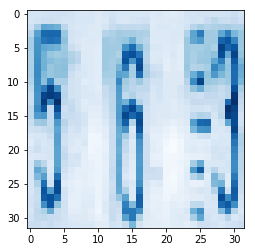

In [36]:
hide_code

image_gray = get_image3('new', '10.png', new_boxes)[0]
print ('File: ', new_filenames[1])
print ('Label: ', new_labels[1])
print ('Categorical label: \n', new_labels_cat[1])
plt.imshow(image_gray, cmap=plt.cm.Blues);

In [41]:
hide_code
image_for_predict = image_gray.reshape(1, 32, 32, 1)
y_image_predict = cnn_model.predict(image_for_predict)
y_predict_example = [np.argmax(y) for y in y_image_predict]

print('Predicted label:')
print(y_predict_example)

Predicted label:
[10, 10, 4, 6, 3]


File:  30.png
Label:  [10 10  7  8  3]
Categorical label: 
 [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]]


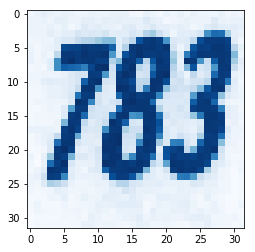

In [38]:
hide_code
image_gray_2 = get_image3('new', '30.png', new_boxes)[0]
print ('File: ', new_filenames[23])
print ('Label: ', new_labels[23])
print ('Categorical label: \n', new_labels_cat[23])
plt.imshow(image_gray_2, cmap=plt.cm.Blues);

In [42]:
hide_code
image_for_predict_2 = image_gray_2.reshape(1, 32, 32, 1)
y_image_predict_2 = cnn_model2.predict(image_for_predict_2)
y_predict_example_2 = [np.argmax(y) for y in y_image_predict_2]

print('Predicted label:')
print(y_predict_example_2)

Predicted label:
[10, 10, 7, 8, 3]


#### Predictions with boxes. OpenCV

In [45]:
hide_code
new_images2_4 = np.array([get_image4('new', x) for x in new_filenames])

X_new4 = new_images2_4.reshape(30, 32, 32, 1)

File:  10.png
Label:  [10 10  5  6  3]
Categorical label: 
 [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]]


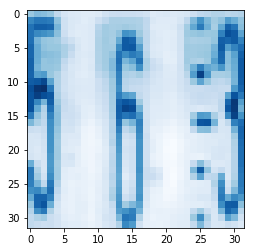

In [46]:
hide_code
image_gray2 = new_images2_4[1]
print ('File: ', new_filenames[1])
print ('Label: ', new_labels[1])
print ('Categorical label: \n', new_labels_cat[1])
plt.imshow(image_gray2, cmap=plt.cm.Blues);

File:  30.png
Label:  [10 10  7  8  3]
Categorical label: 
 [[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]]


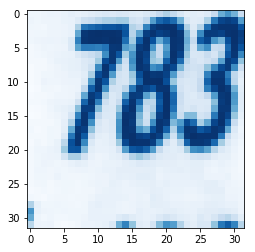

In [47]:
hide_code

image_gray2_2 = new_images2_4[23]
print ('File: ', new_filenames[23])
print ('Label: ', new_labels[23])
print ('Categorical label: \n', new_labels_cat[23])
plt.imshow(image_gray2_2, cmap=plt.cm.Blues);

In [48]:
hide_code
y_new_predict4 = cnn_model.predict(X_new4)
y_predict4 = []
for i in range(30):
    for j in range(5):
        y_predict4.append(np.argmax(y_new_predict4[j][i]))
y_predict4 = np.array(y_predict4).reshape(30,5)
print('CNN Model 1. Predictions: ')
print(y_predict4)

CNN Model 1. Predictions: 
[[10 10 10 10  8]
 [10 10  1  6  3]
 [10 10 10  5  7]
 [10 10 10 10  6]
 [10 10 10  6  1]
 [10 10 10 10  3]
 [10 10  6  4  9]
 [10 10  1  0  1]
 [10 10  1  0  0]
 [10 10  6  1  1]
 [10 10 10  1  4]
 [10 10 10 10  1]
 [10 10  3  4  2]
 [10  2  0  4  0]
 [10 10  3  4  2]
 [10 10 10  7  7]
 [10 10 10  1  4]
 [10 10  4  7  8]
 [10 10 10  1  4]
 [10 10 10  3  0]
 [10 10 10 10  3]
 [10 10  4  4  3]
 [10  2  0  1  0]
 [10 10  7  8  3]
 [10  1  0  3  1]
 [10 10 10 10  1]
 [10 10 10  1  0]
 [10 10 10 10  2]
 [10 10  1  4  9]
 [10 10 10 10  8]]


In [49]:
hide_code
cnn_scores4 = cnn_model.evaluate(X_new4, y_new_cat_list, verbose=0)

print("CNN Model 1. Scores: \n" , (cnn_scores4))
print("CNN Model 1. First digit. Accuracy: %.2f%%" % (cnn_scores4[6]*100))
print("CNN Model 1. Second digit. Accuracy: %.2f%%" % (cnn_scores4[7]*100))
print("CNN Model 1. Third digit. Accuracy: %.2f%%" % (cnn_scores4[8]*100))
print("CNN Model 1. Fourth digit. Accuracy: %.2f%%" % (cnn_scores4[9]*100))
print("CNN Model 1. Fifth digit. Accuracy: %.2f%%" % (cnn_scores4[10]*100))

CNN Model 1. Scores: 
 [16.579042434692383, 1.1920928955078125e-07, 1.6118094921112061, 5.578728199005127, 5.0903453826904297, 4.2981586456298828, 1.0, 0.89999997615814209, 0.63333332538604736, 0.66666668653488159, 0.73333334922790527]
CNN Model 1. First digit. Accuracy: 100.00%
CNN Model 1. Second digit. Accuracy: 90.00%
CNN Model 1. Third digit. Accuracy: 63.33%
CNN Model 1. Fourth digit. Accuracy: 66.67%
CNN Model 1. Fifth digit. Accuracy: 73.33%


In [50]:
hide_code
avg_accuracy4 = sum([cnn_scores4[i] for i in range(6, 11)])/5

print("CNN Model 1. Average Accuracy: %.2f%%" % (avg_accuracy4*100))

CNN Model 1. Average Accuracy: 78.67%


In [51]:
hide_code
y_new_predict4_2 = cnn_model2.predict(X_new4)
y_predict4_2 = []
for i in range(30):
    for j in range(5):
        y_predict4_2.append(np.argmax(y_new_predict4_2[j][i]))
y_predict4_2 = np.array(y_predict4_2).reshape(30,5)
print('CNN Model 2. Predictions: ')
print(y_predict4_2)

CNN Model 2. Predictions: 
[[10 10 10 10  8]
 [10 10  1  1  9]
 [10 10 10  5  5]
 [10 10 10  1  6]
 [10 10 10  5  1]
 [10 10 10 10  8]
 [10 10 10  4  9]
 [10 10  1  0  1]
 [10  1  1  0  0]
 [10  3  2  3  2]
 [10 10 10  1  4]
 [10 10 10  1  1]
 [10 10  3  4  4]
 [10 10 10  1  4]
 [10  2  8  1  7]
 [10 10 10  7  7]
 [10  4  1  1  2]
 [10 10  4  4  8]
 [10 10 10  1  4]
 [10 10 10  3  0]
 [10 10 10 10  3]
 [10 10 10  4  3]
 [10  2  0  1  0]
 [10 10 10  7  9]
 [10  4  0  4  1]
 [10 10  1  7  6]
 [10 10 10  1  0]
 [10 10 10 10  2]
 [10 10 10  7  9]
 [10 10 10 10  8]]


In [52]:
hide_code
cnn_scores4_2 = cnn_model2.evaluate(X_new4, y_new_cat_list, verbose=0)

print("CNN Model 2. CNN Scores: \n" , (cnn_scores4_2))
print("CNN Model 2. First digit. Accuracy: %.2f%%" % (cnn_scores4_2[6]*100))
print("CNN Model 2. Second digit. Accuracy: %.2f%%" % (cnn_scores4_2[7]*100))
print("CNN Model 2. Third digit. Accuracy: %.2f%%" % (cnn_scores4_2[8]*100))
print("CNN Model 2. Fourth digit. Accuracy: %.2f%%" % (cnn_scores4_2[9]*100))
print("CNN Model 2. Fifth digit. Accuracy: %.2f%%" % (cnn_scores4_2[10]*100))

CNN Model 2. CNN Scores: 
 [19.40167236328125, 1.1920928955078125e-07, 2.6863491535186768, 5.057715892791748, 7.788337230682373, 3.8692700862884521, 1.0, 0.83333331346511841, 0.66666668653488159, 0.5, 0.73333334922790527]
CNN Model 2. First digit. Accuracy: 100.00%
CNN Model 2. Second digit. Accuracy: 83.33%
CNN Model 2. Third digit. Accuracy: 66.67%
CNN Model 2. Fourth digit. Accuracy: 50.00%
CNN Model 2. Fifth digit. Accuracy: 73.33%


In [53]:
hide_code
avg_accuracy4_2 = sum([cnn_scores4_2[i] for i in range(6, 11)])/5

print("CNN Model 2. Average Accuracy: %.2f%%" % (avg_accuracy4_2*100))

CNN Model 2. Average Accuracy: 74.67%


---
### Question 10
_How well does your model localize numbers on the testing set from the realistic dataset? Do your classification results change at all with localization included?_
### Answer 10
On the testing realistic set of localized digits, the model works well enough and on average shows the accuracy of predictions about 95 percents. 

I didn't train and test the model on the sets without localization. On my opinion, images include a lot of useless information for digit recognition without localization. This creates unnecessary interference and difficulties for the neural network.

---
### Question 11
_Test the localization function on the images you captured in **Step 3**. Does the model accurately calculate a bounding box for the numbers in the images you found? If you did not use a graphical interface, you may need to investigate the bounding boxes by hand._ Provide an example of the localization created on a captured image.

### Answer 11
The model predicts very well for the newly-captured images with bounding boxes constructed by hand but shows the same accuracy for the programming procedure for finding digits in the photos and for images without bounding boxes at all. It means that I need to improve only the part for cutting image spaces without digits.

I have illustrated this fact by two examples of files.

---
## $\mathfrak {\color{#191970} {Optional \ Step \ 5: \ Build \ an \ Application \ or \ Program \ for \ a \ Model}}$
Take your project one step further. If you're interested, look to build an Android application or even a more robust Python program that can interface with input images and display the classified numbers and even the bounding boxes. You can for example try to build an augmented reality app by overlaying your answer on the image like the [Word Lens](https://en.wikipedia.org/wiki/Word_Lens) app does.

Loading a TensorFlow model into a camera app on Android is demonstrated in the [TensorFlow Android demo app](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/examples/android), which you can simply modify.

If you decide to explore this optional route, be sure to document your interface and implementation, along with significant results you find. You can see the additional rubric items that you could be evaluated on by [following this link](https://review.udacity.com/#!/rubrics/413/view).

In [ ]:
hide_code
#

In [ ]:
hide_code
#

In [ ]:
hide_code
#

### Documentation
Provide additional documentation sufficient for detailing the implementation of the Android application or Python program for visualizing the classification of numbers in images. It should be clear how the program or application works. Demonstrations should be provided. 

In [ ]:
hide_code
#